In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
# Image size and batch size
img_size = (128, 128)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_gen = train_datagen.flow_from_directory(
    "Dataset_Split/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Validation set
val_gen = val_datagen.flow_from_directory(
    "Dataset_Split/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Test set
test_gen = test_datagen.flow_from_directory(
    "Dataset_Split/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important for consistent evaluation
)

Found 3500 images belonging to 2 classes.
Found 750 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

base_model = ResNet50(
    input_shape = (128,128,3),
    include_top = False,
    weights='imagenet'
)

base_model.trainable = False

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False


model = Sequential(
    [
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

In [12]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:

early_stop = EarlyStopping(
    monitor='val_accuracy',     # You can also use 'val_loss' if that's more stable
    patience=3,                 # Wait for 3 epochs of no improvement
    restore_best_weights=True, # Restore the best model (not the last one)
    verbose=1                   # So it prints when it stops
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - accuracy: 0.9711 - loss: 0.0889 - val_accuracy: 0.9413 - val_loss: 0.1566
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.9631 - loss: 0.1081 - val_accuracy: 0.7067 - val_loss: 2.8285
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.9663 - loss: 0.0994 - val_accuracy: 0.7973 - val_loss: 0.6574
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.9674 - loss: 0.0949 - val_accuracy: 0.7693 - val_loss: 1.8733
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:

model.save('models/resnet-model.keras')

In [17]:
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - accuracy: 0.9533 - loss: 0.1226
Test Accuracy: 95.33%
Test Loss: 0.1226


In [3]:
from tensorflow.keras.models import load_model


model = load_model('models/resnet-model.keras')

I0000 00:00:1754141192.009023   13789 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [9]:
predictions = model.predict(test_gen, verbose=1)

predicted_classes = (predictions > 0.5).astype("int32").flatten()

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 360ms/step


In [10]:
from sklearn.metrics import classification_report

true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.92      0.97      0.94       300
       Tumor       0.98      0.94      0.96       450

    accuracy                           0.95       750
   macro avg       0.95      0.96      0.95       750
weighted avg       0.95      0.95      0.95       750



In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

def predict_image(img_path, model, class_labels, img_size=(128, 128)):
    # Load and preprocess the image
    class_labels = list(test_gen.class_indices.keys())
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Since your model was trained with rescale=1./255

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = int(prediction[0][0] > 0.5)  # Binary classification

    # Display image and prediction
    plt.imshow(np.array(img).astype("uint8"))

    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.show()

    return class_labels[predicted_class]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


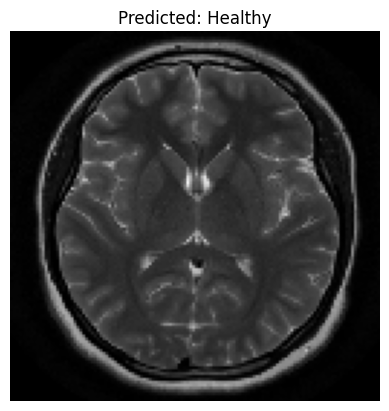

Model Prediction: Healthy


In [17]:
class_labels = list(test_gen.class_indices.keys())

# Predict a single image
result = predict_image("custom_test_images/test_img3.png", model, class_labels)
print("Model Prediction:", result)